In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig, Trainer, TrainingArguments, logging
from datasets import load_dataset, concatenate_datasets, DatasetDict, Dataset
from sklearn.model_selection import train_test_split
from peft import LoraConfig, get_peft_model
from huggingface_hub import notebook_login
import matplotlib.pyplot as plt
import torch.nn as nn
from tools import *
import torch
import os

In [2]:
device = "cuda"
checkpoint = "mistralai/Mistral-7B-Instruct-v0.1"

config = AutoConfig.from_pretrained(checkpoint)
#config.update({'sliding_window' : 8_192}) 
#config.update({'rope_scaling' : {"type": "yarn",
#                                 "factor": 4, 
#                                 "original_max_position_embeddings": 8192,
#                                 "finetuned": True,
#                                }})  


tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast = False, revision = 'main')
model = AutoModelForCausalLM.from_pretrained(checkpoint,
                                            low_cpu_mem_usage = True,
                                            torch_dtype = torch.float16,
                                            revision = 'main',
                                            device_map = 'auto',
                                            use_flash_attention_2 = True,
                                            config = config,)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
lora_r_default = 8
lora_alpha_default = 32
lora_dropout_default = 0.05

lora_config = LoraConfig(
        r=lora_r_default, 
        lora_alpha=lora_alpha_default, 
        lora_dropout=lora_dropout_default,
        bias="none", 
        task_type="CAUSAL_LM",  
        target_modules = ["q_proj", "k_proj", "v_proj"],
        )

model.enable_input_require_grads()
model = get_peft_model(model, lora_config)

In [4]:
path = './model_weights/Mistral-7B-v0.1-context_extension-stage3bis/checkpoint_2400.pt'

def load_weights(model, path):
    saved_weights = torch.load(path)
    param_count = 0
    for key, val in saved_weights['model_state_dict'].items():
        for name, param in model.named_parameters():
            if key == name:
                param.data = val.data
                param_count += val.numel()
                break
    
    print(f'{param_count:,} parameters were loaded successfully.')

load_weights(model, path)

136,056,832 parameters were loaded successfully.


In [5]:
for n,p in model.named_parameters():
    p.data = p.data.to(torch.float16)

In [3]:
import pandas as pd

def loading_data(path):
    df = pd.read_csv(path)
    df = df.astype(str)
    df = df.loc[df["Value"] != "Value"]

    content = ""
    for i in range(df.shape[0]):
        if df.iloc[i]['Value'] == "nan":
            content += "\n" + df.iloc[i]['Attribute'] + " " + "None"
        else:
            content += "\n" + df.iloc[i]['Attribute'] + " " + df.iloc[i]['Value']
    
    return content

In [4]:
model.eval()
prompt = f"""[INST] Record: [ {loading_data('../medical_demo/EX2.csv')} ]
Updated Record: [ {loading_data('../medical_demo/EX2_update.csv')} ] 
Here are an original medical record and its update for a patient. Using bullet points, report the changes that have been made in the Updated Report, ONLY if there was an actual change. [/INST]"""
inputs = tokenizer(prompt, return_tensors='pt').to(device)

with torch.no_grad():
    outputs = model.generate(**inputs, max_new_tokens=900)
    print(tokenizer.decode(outputs[0, inputs['input_ids'].shape[1]:]))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Changes made in the Updated Report:

* Date of patient visit: Changed from 8/24/2022 to 9/12/2023
* Time of patient visit: Changed from 14:30 to 15:30
* Reason for visit: Changed from Annual checkup to Pre-visit for surgery after Achilles tendon rupture during tennis game
* Name of healthcare provider: Changed from Dr. Michelle Clovis to Dr. Michael Frank
* Clinic/Department visited: Changed from 2134 to 2324
* Past illnesses and hospitalizations: Added Incident2: 9/12/2023 serious sprain of the lateral ankle ligament on right foot with Achilles tendon rupture
* Plan for further tests: Added MRI 3 days after surgery
* Referrals to specialists: Added Physical Therapist, sports medicine: Dr. Max Edberg
* Patient instructions - life style: Added Immobilization of ankle: 3 weeks pointed foot, 3 weeks at 90 degrees, ankle rehabilitation: 3 weeks, no walking on foot for 7 weeks minimum
* Billing code for services rendered: Changed from J48372 to J48392
* Cost detail for patient and insuranc

In [10]:
thesis = r"""\chapter{Introduction}
\label{chap:introduction}

The year 2023 is marked as the year of Generative Artificial Intelligence. The development of such models actually started a few years back but some major late advancements, including the public releases of OpenAI's DALL·E and ChatGPT in late 2022 or the leakage of Meta's LLaMA weights in early 2023, created a public excitement for these models. This enthusiasm is only the natural result of the - now proven - capabilities of such models and what they could bring to our society in a near future. If most applications of the early stages development sounded relatively shallow - for instance writing a cover letter with a Large Language Model (LLM) or creating a new logo with a text-to-image model - they only give a glimpse of what will be possible in the next couple of years. For instance, automated speech recognition and transcription could be an enormous workload saver for doctors in the US who have to maintain a thorough record of their discussions with patients - and they could even feed this transcription to a medical LLM providing a first draft of a patient analysis.

\ \\
Both the private industry and the open-source community have been working to unlock the potential of Generative AI models and so far they have been highly successful in their doings. The growing collaboration between Big Tech companies and the open-source community enabled for discoveries every other days. One major obstacle in this field of research is the computational resource required to train Generative AI models. Some models developed have hundreds of billions of parameters and requisite a tremendous amount of computations and thousands of GPUs to be effectively trained. This is both costly (up to several millions of dollars) and time-costly (up to several months). Such research is obviously inaccessible to most companies, universities and individuals and has to be performed by FAANG companies. However, given the buzz in the open-source community around this field, techniques have emerged to make possible reduced-cost training and empower smaller entities.


Amongst those models, Large Language Models have received very special attention. A LLM is designed to process Natural Language (NL) - i.e. regular written text. It can have a specific task such as sentiment classification (e.g. determining if a tweet is angry or happy), machine translation (e.g. translating English sentences to French) or text generation (e.g. predicting the answer to a question). Their large range of possible tasks, their high potential and their easiness to use for the public, make them extremely attractive to the industry. This is especially true since the development of research in the field of small LLMs. With advanced implementation and curated data, some teams have developed small-size general-purpose LLMs (around 7 billion parameters) and were able to outperform mid-size models (up to 30 billion parameters) and even match full-scale models (70 billion parameters and higher) on specific tasks.

\ \\
If LLMs as a whole receive a lot of attention, there is one specific subcategory of LLMs that is even more targeted by this world effort. General-purpose LLMs, or Foundation Models, are designed to learn and retain a tremendous volume of knowledge. The objective is to build a giant database of our society and knowledge as humans. In a way, they are designed to replicate the internet and to this end they are mostly trained with billions of documents taken off of the web. Retaining such a volume of information is challenging, thus Foundation Models are usually extremely large. Their sizes range from a few billions of parameters all the way up to half a trillion of parameters. Once trained and released, they find their utility in downstream applications. With an additional small fine-tuning they can be used for various tasks with extreme accuracy. Fine-tuning is the process of continuing the training of a Pre-Trained Model to specialize it to a specific downstream task. An example is Foundation Model GPT-3 being fine-tuned for Question-Answering tasks into the user-accessible chatbot ChatGPT. Fine-tuning presents the advantage of building task-specific models at a low cost while leveraging the knowledge and capabilities of Pre-Trained Models. The process is as simple as re-using the weights of the Pre-Trained Model during initialization for the new training. More precisely, this is called Full Fine-Tuning as all parameters are updated regardless. Nevertheless, because of the large size of Foundation Models, it can be still inaccessible to smaller entities to fine-tune such models. That is why, the scientific community has developed a large palette of techniques reducing the number of trainable parameters during the fine-tuning phase. This is known as Reduced-Parameters Fine-Tuning.

\ \\
In this report, we first introduce Large Language Models and their architectures by diving in them at a technical level. We then present a range of machine learning methods that helped us build our knowledge before contributing ourselves. Using these previous parts, we lay out the architecture developed for SteloCoder, the training process and the data used, along with the results obtained. Finally, we acknowledge the limitations of our work and propose several areas of improvement for future work.

The first two chapters can be regarded as a large literature review of what we have learned and tried applying while preparing our SteloCoder model. They present a range of techniques that we carefully reviewed and selected to build the perfect model - in the limits of the constraints we faced. Please note that the construction of our model in the last two chapters entirely relies on this and cannot exist without this prior knowledge\footnote{We could re-structure this report to prevent it from having a large block of literature review by including these whenever they rise up, but this would result in a much less intelligible paper. We suggest the technically savvy readers to skip chapters \ref{chap:llm} and \ref{chap:back_work}.}.

\chapter{Large Language Models}

\section{Objective}

Large Language Models are used for various NLP tasks. They usually take a chunk of text as input and can have different types of output. They can be used for sequence/token classification for instance, or for sequence-to-sequence tasks. The latter regroups tasks like text summarization, translation or question/answering\footnote{Actually, sequence-to-sequence designates an even larger range of tasks as it is not restrained to NLP (e.g. audio sequence to text transcription).}. Below, we formalize the mathematical objective of a sequence-to-sequence models as it is representative of LLMs' tasks and can be generalized easily.

Once this distribution is computed, we can select a vector output, for example, using the max-probability output (greedy search). More complex methods \citep{generating1, generating2, generating3} allow to steer, stabilize and enhance the creativity of the output regardless of the actual model (distribution). This has been an active field of research and we leave it here as this not the main subject of this report. Yet, one should really appreciate the importance of the text generation technique chosen as it greatly impacts the Language Modeling (LM) behavior of the model\footnote{The question is addressed much more easily when it comes to other tasks such as text classification.}.

\section{Architecture}
\subsection{Transformer-based}

In 2017, \cite{attention} released the Transformer architecture. They revolutionized the field of NLP as scientists would now exclusively adopt this architecture. It has also impacted other fields more recently, such as Computer Vision in which Transformers have proven efficient \citep{cv_transformer, swin_transformer}. This can be explained by several factors, the most important ones being the capability of the attention mechanism to capture short and long-range dependencies, and the structure that allows easy parallelization of operations taking advantage of multiple GPUs to exceedingly fasten the training.

\ \\
On a high-level, the Transformer-based LLM architecture can be broken down in three parts: the embeddings, the actual transformer and the model head. 

\subsubsection{(Encodings \&) Embeddings}

As mentioned before, the LLM framework suggests a text input. However, it is not possible to perform computations directly on chunks of text. The first problem that needs to be addressed is then the mapping of a Natural Language text to a mathematical input. This is done in two\footnote{three?} steps.

\ \\
Before being fed to the model, the input text is passed through a tokenizer. A tokenizer is usually itself the result of a trained machine learning model that converts a sequence of characters to a sequence of non-negative integers - we call this new representation of the input "the encodings". Formally, this first step consists in mapping the string $\mathbf{x}_\texttt{NL}$ from the $\mathbf{NL}$ language set to an integer-vector representation.

There are various levels of tokenization: character-level (aka byte-level) which converts each single character to a unique non-negative integer \citep{byte-level1, byte-level2}, word-level which converts each word present in the training corpus to a unique non-negative integer \citep{transfoXL} or subword-level which has an intermediary level of tokenization \citep{bert, gpt2}. 

Using a character-level tokenization allows a great flexibility in the model generation as it processes one character at a time, and it limits the vocabulary size as there are only so many letters and characters in a NL text. However, it limits the understanding depth of the language as word semantic is ignored from the model. Additionally, word-level tokenization has a better global computational efficiency because sequences of characters are processed and generated simultaneously. For a $5$-character word we would run the model once, against 5 times for a byte-level tokenization. However, there can be a humongous number of words in a corpus of texts, and while some of them will be very rare, this will directly impact the model size. 

There is obviously a trade-off to find between these methods and that is why subword-level tokenizers were introduced and are the most common tokenization technique. There are plenty of ways to build those using fusion techniques, prefix/suffix separation or frequency based methods for instance \citep{NMT-tokenization, googleNMT-tokenization}. But we are not going to dive deeper in tokenization as this is a whole field of research by itself and not the heart of our study. Again, note that this is an important part of NLP and it can have a great impact on the model's behavior. A tokenizer is always associated and released along with a model as the latter is trained for specific encodings. The tokenizer is not per say part of the LLM but it is intrinsically linked and always used along.
In what follows we refer to the the elements of the encoded vector as "tokens" regardless of the level of tokenization. 

\ \\
At this point, we have a mathematical representation of the input text. These numbers could technically be used for computations in the model. Nevertheless, the encoding process comes with a great issue: it arbitrarily associates a token to a unique number, which naturally orders the tokens. We could imagine trying to make some sense when building this order and ensure that semantically close tokens (such as "cat" and "dog") have close associated encodings, but because $\mathbb{N}$ is only one dimensional we would quickly face the limits of this technique: it would be impossible to capture the range of meanings of one word and how it compares to others in one dimension. This observation lead to the idea of embeddings.

An embedding is the vector representation of a token in higher dimension. This dimension is set large enough to capture the meanings of a word in a higher context while keeping computations at a reasonable level\footnote{Another trade-off we need to select.}. It gives a direct geometrical interpretation of how the tokens relate to each other. One can expect the vector representation of the word "cat" to be close in distance\footnote{There are different ways to define said distance \citep{word-distance, word2vec}.} to "dog" and both of them to be (relatively) far from "peace". We give an example of this representation in figure \ref{embeddings_rep}. Yet, this semantic representation is highly dependent of the context, implying that embeddings usually need to be built with regard to a given corpus of texts. 

\ \\
We have now access to a mathematical semantically-meaningful token-separated representation of our text input. This input embedded matrix is up for further computations through the Transformer blocks. However, let's take a minute here. We remember that one of the advantages of the Transformer architecture is its natural parallel processing of tokens and that all computations are performed simultaneously. This implies that the model, conversely to the RNN architecture, has no natural indication on the tokens order. This is obviously a major shortcoming for the proper understanding and processing of the input since the word order in a sentence can be decisive to its meaning\footnote{A quite eloquent example is provided in Appendix \ref{sec:word-ordering}.}.

When introducing the Transformer, \cite{attention} mentioned and addressed this challenge. Their solution is to explicitly inform the model with the position of each token in the input sequence. To do that they originally proposed to include this positional information in the token embeddings that are passed to the Transformer blocks. Ideally, we would like to provide the information of the relative position between the tokens: the model could then leverage this by focusing more on the token's close dependencies and decreasing its attention over longer range dependencies \citep{APE-issue}. Yet, encoding the relative position information is not straightforward. To circumvent this, they only encoded the absolute position of the tokens (i.e. the rank in the text input). As mentioned, their method includes this position encoding (PE) in the token embeddings, in other words, the positions are encoded as a $d$-dimensional vector which is then summed to the embeddings. Similarly as the token embeddings, this is a mapping from a non-negative integer (absolute position in the sequence) to a real-valued $d$-vector.

\ \\
 Their solution uses a combination of fixed-parameters sine and cosine functions with different frequencies for each token position. Specifically, they use the followings:

This encoding, called Sinusoidal Position Encoding, is able to capture the token's absolute position thanks to its periodic nature. We provide further explanations with an intuitive representation in Appendix \ref{sec:sinusoidalPE}. Additionally, they suspected that this set of functions and frequencies could attend the relative positions as well - this was later formally proven \citep{sinusoidalPE-attendsRPE}.

The authors also introduced an alternative to the Sinusoidal Position Encoding. They proposed along the Learned Position Embedding \citep{attention, learned_PE2}. This method is easier to grasp as it follows the idea of token embedding. The original absolute position encodings (i.e. $1$, $2$, $3$, ...) are fed to an embedding layer of size $(\texttt{embedding\_dimension} \times \texttt{max\_sequence\_length})$. The embedding dimension is the same as the word embedding's so both higher-dimension representations can be added together. The parameters of this embedding layer are freely optimized along with the other layers of the model during training. Although philosophically simpler, the Learned Position Embedding naturally limits the context size. Indeed, once trained\footnote{Once initialized to be exact.} for a given $\texttt{max\_sequence\_length}$, the model is architecturally not able to process more tokens than this limit. Conversely, Sinusoidal PE can extrapolate with larger sequences than seen in training\footnote{In fact, most PE methods have poor performance when it comes to extrapolation. Specific techniques had to be developed for extending the context window of a LLM. We quickly review some of these in section \ref{sec:long-context}.}. In spite of this constraint, many major models have been designed with this embedding method (GPT-family \citep{gpt-1, gpt2, gpt-3, santacoder}, BERT \citep{bert}, ...).

Nowadays, both of these Position Encodings are being progressively abandoned in favor of more efficient methods. Among the most common, we find the Rotary Position Embedding (RoPE) \citep{rope} which re-use the original idea of Sinusoidal PE but directly injects the position information in the attention mechanism\footnote{We present the attention mechanism this just after in section \ref{sssec:transformer_blocks}.} with a matrix of rotation. Another common method is to inject in the attention mechanism the Relative PE (RPE) directly \citep{original-RPE, alibi}. As mentioned above, this was the original intention given that the most important is to understand the position of a word in a given context rather than its absolute position.
Although the research has been extremely active and has produced a large number of position encoding solutions, it is hard to spot a clear winner \citep{nope}. They all have pros and cons and it is up to the architecture designer's best judgement to select one of them\footnote{Let's just mention here some major Foundation Models and their PE method: GPT uses Learned PE \citep{gpt-1}, LLaMA uses RoPE \citep{llama} and T5 uses (an improved) RPE \citep{t5}.}.

\ \\
Whichever PE chosen, the embeddings are fed to the transformer blocks.

\subsubsection{Transformer Blocks}

The second high-level part of a LLM is the actual Transformer\footnote{This is an abusive name employed for the sake of simplicity here. "Transformer" originally designates one layer of an encoder or a decoder.}. This is where the magic happens, where the model learns to analyze tokens and produce new coherent ones. This is the actual NLU / NLG block. This architecture was the main contribution of \cite{attention} which unlocked a new magnitude of performance in NL modelization. 

Right after comes the decoder whose role is to auto-regressively produce output tokens. It uses the encoder's output and the already-predicted output as inputs to generate the next token. To be precise, similarly as the encoder, it produces a vector in a latent space from which we can infer semantic value. It is then naturally oriented towards NLG tasks. Formally\footnote{Using the prism of probability evoked earlier, we observe that the decoder is auto-regressively computing the probability $\mathbb{P}_{\theta_\texttt{dec}}\left( \mathbf{y_i} | \mathbf{\widetilde X}_{dn}, \mathbf{X'}_{d(i-1)} \right)$. Using Bayes' rule we conclude that it can model the  whole target vector distribution \citep{enc-dec-hfblog}.}, for a one-token output this writes\footnote{Taking $d_\texttt{enc}=d$.}:
where $n$ is the number of tokens fed to the encoder, $m$ the number of tokens fed directly to the decoder, $d$ is the hidden size, $d_\texttt{dec}$ is the dimension of the decoder latent space. We usually take $d_\texttt{dec}$ to be equal to the hidden dimension $d$ as well.

\ \\
It is possible to get rid of either the decoder or the encoder when adapted to the situation. Those models are called (resp.) encoder-only and decoder-only transformer models. The original encoder-decoder architecture is displayed in figure \ref{fig:transfo_vaswani}.

An encoder-only model is specialized in analyzing the semantics of a text and will be excellent for sentiment analysis or predicting a masked out token. Examples of encoder-only models would be BERT \citep{bert} or RoBERTa \citep{roberta}.

Conversely, a decoder-only model is specialized in the generative area. It will output high quality chunks of text based on its input. When it is not coupled with an encoder, the only input is the previous text in the context it is working. Thus, the input can be empty\footnote{We pass a \texttt{beginning-of-sentence} token marker to get the model started.} or a simulated prior text, concatenated with the previously auto-generated tokens. A decoder-only model is generally employed for text generation tasks like question/answering or text summarization. Examples of decoder-only models would be LLaMA \citep{llama}, GPT \citep{gpt-3} or Falcon \citep{falcon}.

Finally, encoder-decoder models are used when the task requires a high level of both NLU and NLG. In the cases of language translation and speech-to-text transcription for instance, they can prove more efficient than encoder-only or decoder-only. Examples of encoder-decoder models would be BART \citep{bart}, T5 \citep{t5} or Whisper \citep{whisper}.

Let's now dive inside one block and get a technical feeling of how it works.\footnote{The encoder and decoder block architectures being extremely close, we detail the architecture of a generic Transformer block and carefully flag whenever something differs between the two.} Essentially, the Transformer is composed of the Attention Mechanism (AM) and a Feed-Forward Network (FFN). It also features skip connections and normalization layers located - originally \citep{attention} - right after them. In more recent works, the normalization layers have been moved before the AM and FFN \citep{gpt2}. Other than that, it has remained the same throughout the years. 

\ \\
The Attention Mechanism is the core process of the model. It is the part modeling the dependencies between tokens and creating an attention score. To this end, the input embedded tokens are triply projected, via the use of linear layers, into the \texttt{query} $\mathbf{Q}$, \texttt{key} $\mathbf{K}$, and \texttt{value} $\mathbf{V}$ matrices\footnote{The dimension of the attention matrices is usually the hidden dimension $d$.}. We can then compute the self-attention with the following formula:
\begin{equation*}
    \texttt{attention} \left(\mathbf{Q}, \mathbf{K}, \mathbf{V} \right) = \texttt{softmax}\left( \dfrac{\mathbf{Q} \mathbf{K}^T}{\sqrt{d_k}}\right)\mathbf{V}
\end{equation*}
where $d_k$ is the dimension of the \texttt{keys}. This formula allows the tokens to attend all of each other and $1/\sqrt{d_k}$ plays the role of a scaling factor.


However this self-attention is a bit different for the decoder blocks. In this case, we want a given token to only be aware of what comes before itself (auto-regressive). If it were able to see in the "future" it would be cheating and lead to poor performance as in inference it would not be able to do so. Then we use an attention mask to mask out the future tokens after the first matrix multiplication (triangulation)\footnote{We also distinguish the encoder and decoder blocks by using the nomenclatures "bidirectional transformer" and "left-to-right transformer".}. 

Moreover, in the case of a decoder block from an encoder-decoder model (and only in this case\footnote{This is skipped in a decoder block from a decoder-only model.}), this self-attention is followed by a cross-attention layer. The principle is the same but allows to acknowledge the output of the prior encoder. The \texttt{query} matrix in the cross-attention formula is still projected from the decoder's inputs but the \texttt{keys} and \texttt{values} are from the encoder's outputs. This allows the decoder tokens, in an encoder-decoder, to attend over all tokens in the input sequence processed through the encoder.

\ \\
This was the description of how a single attention head works. To enhance the capability of the overall attention network, a model generally includes multiple heads that are run in parallel. They break the projection dimension in multiple blocks ($d_k = h \times d_k$, where $h \in \mathbb{N}^*$ is the number of heads) to keep a similar calculation cost. Having multiple heads allows "to jointly attend to information from different representation subspaces at different positions" \citep{attention}. Finally, these are concatenated and projected back to the hidden dimension. This very commonly used process is called Multi-Head Attention.

\ \\
Although powerful, the AM has quadratic complexity in the sequence length, making it the bottleneck when it comes to scaling. This has been a major concern in the community and has been addressed by a large number of scientists. Many papers have tried to accelerate the AM process, sometimes at the cost of a reduced precision. Some techniques modify the attention to tend toward a linear complexity \citep{sparse-attn, reformer-attn, long-attn, lin-attn}, other impact the multi-head architecture \citep{multi-query, grouped-query}, or propose optimization in the calculations process \citep{flash-attn1, flash-attn2}. Some of them are now extremely popular and widely used, even in the pre-training phase of Foundation Models \citep{mistral}. 

\ \\
Still in the Transformer block, after the AM, the tensors are processed through a fully-connected Feed-Forward Network which is a Multi-Layer Perceptron (MLP) composed of two linear layers. The MLP is philosophically dedicated to "making sense" out of the attention analysis. This part of the model does not present any specificity so we don't extend on this.

\chapter{Background Work}

In this chapter, we continue our theoretical journey of the study of LLMs. We introduce several machine learning techniques that can be applied to (but not only) LLMs to leverage their potential and ensure an optimal performance. They are diverse, providing architecture enhancements or dataset optimization, and form an excellent foundation knowledge to reach our final objective of building our own code translation LLM.


\section{Mixture-of-Experts}

The Mixture-of-Experts (MoE) \citep{moe} originates from the observation that to improve the capability of NNs, the common usage is to increase the size and number of parameters. However, doing so necessarily worsens the efficiency of the model by increasing the latency. The MoE proposes to solve this by expending the number of parameters while only using a small number when actually using the model. Most nodes end-up unused when an example is passed, which allows to maintain the original efficiency. The core idea lies in the hypothesis that the parameters will tend towards domain experts and will be activated only when an example of their knowledge domain is fed. 

\ \\
This design is formalized with a set of $N$ experts and a gating\footnote{Also called routing in what follows.} network. The experts $E_i$ are not bound to share the same architecture but they tend to in the literature\footnote{They all are 2-layer FFN in the original MoE paper.}. The only constraint is they should all require similar input shape and produce similar output shape. The gating network $\mathbf{G}$ is usually a simple weight matrix whose second dimension is the number of experts. This layer selects a small number of experts $k\leq N$\footnote{We could use them all or a larger number but that would defeat the original purpose of the paper. The actual name is "Sparsely-Gated MoE".} to route to. And the input is sent to those experts. The final output of the MoE module is the weighted sum of the selected-expert' outputs.
This formula leverages the capability of multiple experts and trains them on specific domain examples. This reduces the complexity of the problem each expert has to solve. We can expect to unlock a new magnitude of performance when compared to the original model.

\ \\
Although quite simple, the MoE presents some delicate challenges related to the training phase. Firstly, we need to introduce the sparsity constraint in the $\mathbf{G}$ formula. Secondly, training such a network raises the question of bias in the experts chosen. Indeed, during the first step, the network will select $k$ experts for the first time. This experts will see their weights updated during the optimization step. As they are the only experts updated at this point, they probably have a better performance than others and are more likely to be selected by the routing network in what follows. If we do nothing, then a vicious circle takes over and only a couple of experts will be trained and used, defeating the advantage of having $N$ experts. To counteract this, the authors introduce noise in the training phase which should balance the examples fed to the experts\footnote{To be exhaustive, they also and mainly propose an additional loss to the model. This loss encourages all experts to have similar importance and acts via backpropagation.}. The gating network they use can be written as:
\begin{equation*}
    \mathbf{G}(\mathbf{x}) = \texttt{softmax} \left( \texttt{KeepTopK} \left( \mathbf{H}(\mathbf{x}), k  \right) \right)
\end{equation*}
with 
\begin{equation*}
    H(\mathbf{x})_i = \left( \mathbf{x} \cdot \mathbf{W}_g \right)_i + \mathcal{N}_i \cdot \texttt{softplus} \left( \left( \mathbf{x} \cdot \mathbf{W}_n \right)_i \right)
\end{equation*}
and
\begin{equation*}
    \texttt{KeepTopK} \left( \mathbf{v}, k \right)_i =
    \left\{
    \begin{array}{ll}
    v_i &\quad \text{if $v_i$ is among the top $k$ elements of $\mathbf{v}$}\\
    -\infty &\quad \text{otherwise}
    \end{array}
    \right.
\end{equation*}
where $\mathbf{W}_g$ is the gating weight matrix, $\mathbf{W}_n$ is a noise trainable matrix and $\mathcal{N}_i$ is the random result of a draw from a normal distribution.

In a nutshell, the MoE architecture comes from a simple idea and applies it in a natural way with the objective to unlock performance by augmenting the parameters without slowing the model. Previous papers have demonstrated its effectiveness in multiple contexts \citep{demix-moe, paramefficient-moe}. Yet, some challenges regarding the training of such non-continuous and non-sequential network oblige a certain number of mathematical tricks, making the actual model and implementation relatively complex.


\section{Parameter Efficient Fine-Tuning}

The first idea that comes to mind is to simply select a reduced number of parameters that we want to update and freeze the rest during training. If this is technically an easy-to-implement possibility, it can be difficult to guess which parameters to keep unfrozen for an optimal fine-tuning. Moreover, because of the repetitive nature of the LLM architecture (based on similar sequential blocks), if one wants to affect one part they will actually impact $N$ times the network ($N$ being the number of blocks). This partially defeats the reducing-the-parameters-to-train idea.

A plethora of more elaborated and more efficient techniques have been developed (see figure \ref{fig:survey_peft}). In this section, we present a couple of those that we tried and which unveiled potential. 
\begin{figure}[ht]
    \centering
    \includegraphics[width=.8
\textwidth]{Photos/survey_peft.png}
    \caption[PEFT methods taxonomy]{PEFT methods taxonomy \citep{survey_peft}.}
    \label{fig:survey_peft}
\end{figure}


\subsection{Adapters}

An excellent alternative to selecting parameters in our network is to add a new set of parameters. In between layers or alongside, we can attach a small module with brand new parameters. This method is called "Adapter" and was first introduced in 2019 \citep{adapter}.  They proved to work well for LLMs and further works have leveraged this idea. \citep{llamaadapter} provides an efficient Adapter framework for LLaMA-based models.

\begin{figure}[ht]
    \centering
    \includegraphics[width=.7\textwidth]{Photos/adapter.png}
    \caption[Example of Adapter architecture]{Example of Adapter architecture \citep{adapter}.}
    \label{fig:adapter}
\end{figure}

The Adapter method allows to control the number of added parameters\footnote{Usually from as low as $0.1\%$ to a couple of percents} as well as their location in the network. One can easily adapt the architecture of its module and the incorporation method (series vs. parallel). Using additional modules instead of updating the parameters of the network is a great feature to counter the catastrophic forgetting\footnote{Catastrophic forgetting is a known issue of reckless fine-tuning: if not done properly, the change in the original parameters can lead to a decreased performance as the model may jump out of a local minimum and forget part of its pre-training data \citep{catastrophic_forgetting}.}. They are also flexible and can be easily removed to revert to the original model. With an Adapter Fine-Tuning, sharing a new model can be done through sharing the Adapter module weights only\footnote{And by letting the receiver know the base model used of course.}.

On the other hand, Adapters present a couple of cons. They introduced newly initialized weights which need a training from scratch. Even if it's a small number, it may be more difficult to train from scratch than adjusting existing parameters. They come with a lot of flexibility, maybe too much. One needs to figure out the size, the architecture and the location of Adapters. It might take a while to figure out the perfect setup. Technically, it can be uneasy to change the architecture of the original model, and to share the fine-tuned model one also needs to share exactly how to reproduce it. And finally, they introduce a small latency as they come with new parameters.

\subsection{Low-Rank Adaptation}
As of 2023, the most popular PEFT method is the Low-Rank Adaptation (LoRA) \citep{lora}. This method is also a special case of the more general Adapter framework. When developing this method, the authors made the assumption that the weights update matrix $\Delta \mathbf{W}$ of a given weights matrix $\mathbf{W}$ of a linear layer in a neural network is usually over-parameterized. According to this, the update weights matrix would actually have a low intrinsic rank, meaning it could be re-written as a multiplication of two lower-rank matrices. Thus, LoRA introduces this lower-rank representation of the matrix $\Delta \mathbf{W}$ and trains it while keeping the original dense matrix frozen.

Precisely, here are the steps to implement the LoRA method for a given linear layer of matrix $\mathbf{W} \in \mathbb{R}^{d\times k}$:
\begin{enumerate}
    \item Choose a small rank $r\in \mathbb{N}^*$ that will represent the low-rank representation of the dense matrix, and set $\alpha \in \mathbb{R}_{*}^{+}$ as the scaling factor.
    \item Introduce two matrices\footnote{aka LoRA weights.} $\mathbf{A}\in \mathbb{R}^{r\times k}$ and $\mathbf{B}\in \mathbb{R}^{d\times r}$.
    \item Initialize $\mathbf{A} \sim \mathcal{N}\left(0, \sigma^2 \right)$ and $\mathbf{B} = \mathbf{0}$.
    \item Freeze $\mathbf{W}$ (prevent weight updates).
    \item Compute the forward pass $\mathbf{h}(\mathbf{x}) = \mathbf{W}\mathbf{x} + \dfrac{\alpha}{r} \cdot \mathbf{BAx}$.
    \item Update $\mathbf{A}$ and $\mathbf{B}$ in the backward pass.
\end{enumerate}

The forward pass is the result of passing the input to both the original matrix and the new ones in parallel, and adding the results together. This is visualizable in figure \ref{fig:lora}. 

LoRA benefits from all the advantages of the Adapters framework but it has additional pros own to itself. It further reduces the number of parameters (low rank $r$) sometimes by a huge factor (up to a $10^4$ reduction). It also decreases the degrees of freedom to more tangible parameters ($r$, $\alpha$, list of dense layers to LoRA-fy) in comparison to the quasi-infinite possibilities of the general Adapter. And the most important feature of LoRA is its nature that allows it to be merged with the original model: performing the update operation $\mathbf{W} \leftarrow \mathbf{W} + \dfrac{\alpha}{r} \cdot \mathbf{BA}$ enables to remove the LoRA weights and avoid any computation overhead and latency, and to fall back to the original architecture. Then, one can choose to merge the LoRA weights after training or keep them in parallel to fit best their application.

\begin{figure}[ht]
    \centering
    \includegraphics[width=.7\textwidth]{Photos/lora.pdf}
    \caption[LoRA's forward pass]{LoRA's forward pass. On the left, the LoRA module is not merged with the model. On the right, the LoRA module has been merged with the model.}
    \label{fig:lora}
\end{figure}

As mentioned, LoRA is extremely famous because of these advantages and because, in some cases, it can match or outperform full fine-tuning's performance.

\subsection{Unified PEFT Framework}
\label{ssec:unified_peft}

Before wrapping up this PEFT section, we just want to mention the recent efforts trying to unify all these methods. Huggingface built a PEFT library \citep{peft} to gather these techniques under one framework that allows the users to seamlessly switch their fine-tuning method. Additionally, \cite{unifiedpeft} mathematically proved an equivalence between multiple PEFT techniques (including the ones we discussed above) and regrouped them all under a unified architecture. \cite{llmadapters} participated to this effort as well.

\ \\
This last observation gives us a hint that combining these fine-tuning methods, even if orthogonal, may not bring consistent improvements over just using one.


\section{Curriculum Learning}
Humans learn at school through a very organized and carefully designed curriculum. The education system has been evolving to optimize our understanding and learning efficiency\footnote{Or at least it tries to...}. In general, a teacher will prone increasing the complexity over time to facilitate the grasping of new knowledge to their students. They will first introduce basic concepts alongside accessible examples so the students can conveniently use their prior knowledge to make sense out of this new information. Once they are familiar with the basics, the teacher will introduce new elements of increasing complexity. This way the students can progressively build their knowledge relying on their prior understanding. 

\ \\
Curriculum Learning (CL) \citep{curriculum} emerged from this idea. The authors hypothesized that if humans learn progressively best, then it is also probably the case for neural networks\footnote{Reinforcing the analogy with the human brain.}. CL is a machine learning technique that can be applied to any problem since it defines an order strategy on the dataset and has no impact on the model's architecture.

The original CL paper proposes to define an ordering strategy on the dataset used to train the model. By showing first the "easy" examples and gradually increasing the complexity of examples fed, the model is expected to grasp concepts faster and more consistently. The authors came to this conclusion that a machine learning model trained with a CL strategy can achieve a better performance within less training steps. 

Overall, CL strategies improve consistently the convergence towards a local minimum for highly non-convex functions (such as the large neural networks functions) and work as a regularizer in the training process for a very low cost (when kept simple). 


\chapter{SteloCoder}

\section{Motivation}

A very common use case of Large Language models is coding assistants. LLMs can be of great help to workers, especially in the world of tech. Because of their natural ability to regroup knowledge in one place and because software engineers and machine learning engineers were the ones to develop such models in the first place, it only made sense for them to leverage LLMs in their everyday work. Thus, asking help from a LLM such as ChatGPT with a code snippet, either for example generation, description in natural language or translation to another Programming Language (PL) has become an extremely common action in tech companies. 

Of those use cases, one caught our attention. Translating a code snippet from a programming language to another one is crucial in some fields. It could help companies migrate their code from one technology to another seamlessly. This is vastly important as in some companies (and sometimes field-wide) old technology is still currently in use and need to be replaced. Yet, the technology has been abandoned for so long that only a few people are still knowledgeable with it, making the transition exceedingly tedious and expensive. A prime example of this is the coding language Cobol\footnote{We give an example of Cobol snippet in Appendix \ref{sec:cobol}.} which is the base foundation of many finance companies while being completely outdated and unknown to most engineers of today.

\ \\
We propose to address this need. We are not the first to come up with the idea of building a Programming Language Model (PLM), many PLM already exist and were designed for different tasks with different objective and different capability and performance. Among those PLMs, some tend to be developed as Foundation Models so they can be used for any coding task (in-filling, translation, generation, NL explanation...) as a complete AI coding assistant. Other prefer to leverage them for a specific fine-tuning and enhance the capability of a model in a specific domain.

Our project follows this last maxim and we aim to develop a translation-specialized PLM. Precisely, we aim to design, build and train a PLM to translate snippets (and potentially larger chunks) of code from any programming language to Python. We acknowledge that Python is one of the most known and used PL and imagine that it would be useful to programmers. We restrict ourselves this way, hoping that we can improve state-of-the-art models on this specific task.


\section{Architecture}

\subsection{Base Model: StarCoder}


Using our knowledge of LLMs\footnote{See chapter \ref{chap:llm}}, we quickly figured out that an encoder-decoder model is adapted to the translation task. Indeed, the encoder unveil the complex and intrinsic dependencies of the tokens to map the original sentence to a high-dimensional representation of this information. The decoder can use this abstract representation to auto-regressively generate a corresponding sentence. Such models have actually been extensively used for translation tasks producing SOTA results \citep{attention}.

However, even if originally developed as encoder-decoder, transformer models have in majority first shifted to encoder-only and recently to decoder-only (see figure \ref{fig:survey_llm}). This implies that the Foundational SOTA Models of today are almost exclusively decoder-only models. As we cannot ignore the advantage of an existing pre-trained model, we resign ourselves to selecting one from the decoder-only pool.

\ \\
Finally, because we want to design a model that deals exclusively with programming language, we focus on models that have a very large part of their pre-training data to be code. In fact, we even note the existence of Foundation Models for programming language and decide these are our best bet. Among those, we select the SOTA model\footnote{At the time...}: StarCoder \citep{starcoder}.

\subsubsection{StarCoderBase \& StarCoder}
StarCoderBase \citep{santacoder} is a Foundation Model built by the BigCode community which regroups a large number of engineers and organizations. It's a $15.5$B-parameter model, built on the BigCode architecture \citep{santacoder} and trained on $1$T tokens of programming-related corpus and languages. This model is designed to understand and generate code from a large range of programming languages. It can fill-in code, explain an algorithm, answer coding questions, generate code in plenty of languages, create a documentation or comments,... In a word, it's a coding assistant.

StarCoder is a fine-tuned model from StarCoderBase on a large Python dataset. This model has the same capabilities as the original one but is specialized for Python. This training process produces state-of-the-art results on Python code-related tasks \citep{starcoder-sota}.

\ \\
StarCoder's architecture is following the original Transformer decoder-only architecture with the following characteristics\footnote{We focus on the characteristics presented in our previous chapters - which are not exhaustive.}:
\begin{itemize}
    \item Decoder blocks: $40$
    \item Vocabulary size: $49152$
    \item Max sequence length: $8192$
    \item Hidden size: $6144$
    \item MLP intermediate size: $24576$
    \item Attention Head: $48$
    \item Position encodings: Learned Position Encoding\footnote{Which makes the max sequence length a hard constraint.}
    \item Attention Mechanism: Vanilla + Multi-Query\footnote{\cite{multi-query}.}
    \item Head: Causal Head
\end{itemize}


\subsection{SteloCoder's Little Twist}
SteloCoder re-use the architecture of StarCoder as its backbone, but it's not its whole design. From the knowledge gathered prior to this work and partly presented in chapters \ref{chap:introduction} and \ref{chap:back_work}, we acknowledge that we cannot fine-tune the whole model. But also that having specialized modules enhances the capability of a model. Usually, it comes at a cost of additional parameters that may create latency and mitigate the possibility of a multi-task model. However, to circumvent this we propose to combine the LoRA and MoE techniques. 

\ \\
Our prior experiments led us to select LoRA as our fine-tuning method as it yields great performance along plenty of advantages evoked earlier. We actually decide to LoRA fine-tune the model one time for each language we want our model to handle. For each programming language, we get a set of LoRA weights (which are almost negligible in size in comparison to the backbone model) and store them. 

In the final model, the LoRA weights are kept on the side, on a parallel route to the spine, and only one set of parameters is selected during inference. The selected set should correspond to the PL passed as input. This way, we leverage the specialization of each LoRA module in a greater multi-language network at practically no latency or memory costs. In other words, we shift the MoE idea of multiple experts for improved precision on one task to multiple experts for multiple tasks.
Another advantage of this design, is the possibility to easily add additional experts later. One could improve the model by adding support for more languages by training new experts without having to re-train (or re-fine-tune) the whole model. This also greatly reduces the risk of catastrophic forgetting.

\ \\
LoRA is applied to three matrices in the attention mechanism (the linear layer producing the query, keys and values which is one matrix in BigCode implementation, the attention projection layer, and the MLP projection layer) within all $40$ transformer blocks.The LoRA weight are parametrized with $r = 4$ and $\alpha = 32$. This sums up to an additional $9$M parameters per expert (around $0.06\%$ of the total).

\ \\
A major challenge of this design is the question of selecting the expert to use. We want the model to seamlessly choose the right expert. To achieve this we get inspiration from the MoE routing network. The original MoE gating has extra layers of complexity that we don't need in our case (especially because we want to select only one expert and because there are low risks of experts imbalance due to multitasking). We simplify and adapt the original architecture so it is reduced down to a linear layer coupled with a max pooling as shown in figure \ref{fig:routing_path}. The linear layer projects the input to a dimension of size equal to the number of experts (i.e. equal to the number of PL handled) and then the max pooling aggregates the information along the sequence length dimension. The output is softmaxed to yield interpretable probability and we assume the index of max-probability to be the right expert to select: this index is propagated throughout the network\footnote{Note that the final version is implemented at a batch-level, meaning we can pass multiple inputs from different PL as one batch and the model will select the right expert for each input of the batch. This is true for the training mode, and almost for the inference mode (see the GitHub repository). But usually, in inference, the batch size is $1$.}.

\section{XLCost Framework}

\subsection{XLCost Dataset}
The data was gathered from the website GeeksForGeeks which proposes data structures and algorithms problems. It also hosts the solution in various PLs. Examples of such problems would be writing an algorithm to determine the first prime numbers or the first elements of the Fibonacci sequence. 

This dataset is available via GitHub and has been used as an evaluation framework for various models on various tasks. The results are displayed for open comparison. We discuss in the next subsection the important models and results for our application.

\ \\
The XLCost dataset provides data for $7$ PLs: Python, C++, C\#, C, JavaScript, Java and PHP. The amount of available data for each language is relatively balanced, except for C which presents only a few examples in comparison. To avoid issues later in training\footnote{Some effort could be put into augmenting the data but this not our focus in this project.}, we decide to drop the C language from our scope. Table \ref{table:data} sums up the available data.


\subsection{CodeBLEU Metric}

A metric that is not perfect but was created with these thoughts is the CodeBLEU Score \citep{codebleu}. It is derived from the BLEU (Bilingual Evaluation Understudy) Score metric \citep{bleu} that itself is designed for comparing a machine-generated translation with a reference translation. It works from a complex formula mixing the n-gram precision and a penalty for the brevity of the generated text. It is now commonly used as it has displayed a high correlation with human judgment and provides an automatic low-cost evaluation. 

CodeBLEU extends this idea by applying the same principles to programming language generation tasks. Instead of comparing the generated code to a set of predefined references, CodeBLEU uses a combination of syntactic and semantic evaluation methods to assess the quality of the generated code which is more adapted in regards to the difficulties mentioned above. Interestingly, it can be interpreted as a percentage, with a
balanced-weighted addition of BLEU, weighted BLEU, syntax match, and data-flow match.

\ \\
That's why the CodeBLEU score is used to assess the quality of the outputs generated by the models evaluated on the XLCost test dataset. Models fine-tuned on the train set can be compared by computing their CodeBLEU score on the test set.


\subsection{Baseline Models}
The XLCost framework also refers to a set of models that have been fine-tuned and tested on the datasets by the authors. They initialize a couple of models with the pre-trained weights and default configuration from the original papers. They use their dataset to test them on different downstream tasks, including PL translation. They evaluate them using the CodeBLEU score and record the results in tables. This creates a benchmark for each task in the XLCost framework and allows future experiments to test and compare other models with their benchmark.

\ \\
The models tested are CodeBERT \citep{codebert}, PLBART \citep{plbart} and CodeT5 \citep{codet5}. CodeBERT is inspired from BERT methodology, it's one of the very first PL models and it's able to generate text from multiple PLs. PLBART, which re-uses BART architecture, thrives in code summarization, generation and translation. CodeT5, the latest, is established based on T5 architecture and provides state-of-the-art results in both code understanding and generation on various tasks.

All three of them have been tested on the XLCosts tasks. The results are available on the GitHub page. We provide their CodeBLUE score for the PL-to-Python translation task in tables \ref{table:baseline-snippet} and \ref{table:baseline-program}. CodeT5 performs the best for all PL-to-Python translations in the XLCost framework. 

Note that this baseline models were trained and tested for all tasks in the XLCost framework, including PL translation to other languages than Python. We provide in Appendix \ref{sec:codeblue} more results on these translation tasks.


\section{Training Process}
Now that we have the model, the data, the evaluation metric and some baselines to compare to, we can focus on the actual training. 

\ \\
Given the specific architecture that we have developed for SteloCoder, we decide that having a two-step training is the best thing to do. Indeed, we will first train each language individually as this corresponds to a regular LoRA fine-tuning of StarCoder. This will produce the sets\footnote{There will be $5$ sets of weights in total as this is the number of PLs our model will handle in the translation to Python task (C++, C\#, JavaScript, Java, PHP).} of experts that will be kept on the side and route towards to in the final model. In a second and final step, we will train the routing gate - which as a reminder is only a linear layer - to choose the right now-trained experts to route the examples to.

\ \\
This process breakdown is possible given the separation of the tasks and we expect it to stabilize and facilitate the global training of the network.


\subsection{Phase 1: Experts Training}
The first phase is dedicated to training the sets of experts one by one in regards to their task. That is to say, we fine-tune StarCoder with the LoRA technique to translate code from C++ to Python. Then, we fine-tune again the original StarCoder to translate C\# to Python. And so on for all $5$ PLs. Once a set of weights is trained it is stored as it is to be re-used in the second phase.

During this phase, all parameters are frozen except the LoRA weights.

\ \\
We adopt the self-supervised strategy as foreshadowed in chapter \ref{chap:llm}\footnote{We did not extend on this but there are obviously multiple training strategies according to the task and architecture of the model.}. The model receives as input the code in the original PL along with the concatenated Python translation. The reference label (to predict) for the model is then the same string: the model learns to predict the future tokens by judiciously adding a beginning-of-code marker token in the concatenation. We teach the model to predict the tokens following the beginning-of-code marker token\footnote{This is not the usual method in translation as we tend to use encoder-decoder models that can adopt different training strategies.}. Precisely, the input (and label) follows this structure: \texttt{<PL name> code in the given PL <py> Python code translation <|end-of-text|>}. In inference, we will provide the string \texttt{<PL name> code in the given PL <py>} and the model will predict the Python translation tokens until the end-of-text token, which signals the end of the task.

\subsection{Phase 2: Gate Training}
Once all the experts are trained and ready to use, we can gather them and prepare the final architecture. The experts need to be routed to via the routing gate. This MoE gate is the last piece we need to train. In this phase, these are the only parameters that are updated, everything else is frozen including the experts.

\ \\
The MoE gate training rose a challenge linked to the use of the maximum probability. As a reminder, the output of this linear layer is softmaxed to create a probability-like output. We can then select the max-probability index as the expert to route to. However, the \texttt{argmax} operation is not differentiable which prevents a backpropagation. A solution to this is to adopt slightly different behaviors in training and inference. During training, instead of using only the max-probability expert, we use the output of the softmax as weights. We pass the input through all the experts and calculate the weighted average of the outputs as our final expert output. This enables the backward propagation. 

Over training, the model encourages greater weight on the right expert, and during inference only this one will be used. \cite{training-routing} proposes a similar solution as ours for training the gate.

\section{Results}

\subsection{Individual Experts}
We test the experts one by one to assess the quality of the generated translation when the right expert is used (at the end of phase $1$). We use the XLCost framework for fair comparison with previous work. We then use the XLCost test datasets and the CodeBLUE score as metric. Each expert is tested solely for the language it was trained for.

\ \\
A recurrent issue we spot in the code generation is the model's tendency to repeat a character, a word or a group of words an infinite number of times (until maximum generation reached)\footnote{This suggests that a better text generation sampling method could probably improve the model's behavior.}. We also note the inconsistent performance when reproducing some common functions syntax (linked to the \texttt{main} function) which, after a closer look, we notice to be missing from the snippet-level data (only present in the program-level data).

\subsection{Routing Gate}
We measure the quality of our routing process by recording the accuracy of the expert-choosing task. On the XLCost balanced validation dataset, the routing process reached an accuracy of $91\%$. This is a pretty good result. We provide a breakdown analysis of chosen experts in table \ref{table:routing_accuracy}.

\begin{table}[ht]
\centering
\begin{tabular}{cccccc}
           & C++ & PHP & JavaScript & C\# & Java \\ \cline{2-6} 
C++        & 149 & 0   & 1          & 0   & 3    \\
PHP        & 1   & 152 & 0          & 0   & 0    \\
JavaScript & 1   & 0   & 145        & 0   & 0    \\
C\#        & 2   & 1   & 7          & 150 & 47   \\
Java       & 0   & 0   & 0          & 3   & 103  \\ \toprule
Total      & 153 & 153 & 153        & 153 & 153 
\end{tabular}
\caption[Experts-routing confusion matrix]{Validation Confusion Matrix. The predictions are on the left (rows), the true labels are above (columns). The global accuracy is $91.3\%$.}
\label{table:routing_accuracy}
\end{table}

\ \\
Analyzing the experts chosen suggests that the routing struggles the most for languages that have similar syntaxes such as C\# and Java. We assume that longer context could solve at least partially the issue. Nevertheless, we also point out that this is far from being a major issue and even might be and advantage: if the languages are close enough then the associated experts will have no issue translating one language or the other regardless of which one it was trained for, the routing can then select the expert that will perform the best for the given specific input (increases the degrees of freedom for these languages).
This last observation let us assume that the final model should present equivalent or better result than individual experts in table \ref{table:experts-results}.


\subsection{SteloCoder}
We now test SteloCoder on test cases from the XLCoST framework and display the results in table \ref{table:stelocoder_results}. Except for the PHP language, SteloCoder beats the XLCost benchmark in terms of CodeBLUE score. We interpret this as two sided: on the one hand we have trained specialized expert for each specific task enhancing the capability of the network on each one of them, on the other we believe that StarCoder's original ability to produce qualitative Python code made such high scores possible.

\ \\
We also compare the final model output against the original single-expert fine-tuned models outputs and observe that the routing network do not harm the performance. In some cases we even observed a slight improvement as suggested above. 

\ \\
We refer to Appendix \ref{ssec:translation_examples} for samples of translation performed by SteloCoder.


\chapter{Limitations \& Future Work}

Building this project was extremely informative as it was only possible by first acquiring a somewhat deep and solid knowledge on multiple aspects of the subject. We are very satisfied with the results, as much as we are with the journey that got us here.

\ \\
But our journey does not end just yet. Analyzing the results, and putting them in regards to the design choices we made is important to understand the impact of each one of them. In this chapter we propose an overview of a couple of limitations we identified in our work, along with several aspects that could be the object of further study.

\section{Limitations}

\subsection{Model Weaknesses}
\subsubsection{Post-Processing Pipeline}
SteloCoder looks very good when it comes to code translation. However, we kept under the hood an aspect of the translation pipeline. There is an important question around the data formatting that is fed to the model and how it should be designed to come out right of the model. This design question has to be answered before the training since the model will follow exactly the training labels. This requires a precise and careful pre-processing of the data.

\ \\
In the case of SteloCoder, we made several poor design choices and went over the pre-processing part (too) quickly. This resulted in a generation format that is not consistent, especially for spaces. Sometimes the model will produce double spaces for no solid reason for instance. Most of the time, this is not a major issue as Python can still be interpreted easily.
However, in our case, because we evaluate the performance using an automated metric we need the format to be consistent and correct. Especially with the CodeBLUE score, the results can greatly vary because of syntax, format or style discrepancies. 

\ \\
To address this, and make our evaluation consistent with the other models tested in the benchmark, we added a post-processing pipeline to re-format the generated code to the right format. This is a similar add-on as done by \cite{whisper}.
Among other, the pipeline handles the spaces issue, removes add-on tokens (for PL name, Python and end-of-text), and re-format \texttt{NEW\_LINE}, \texttt{INDENT} and \texttt{DEDENT} tokens.


\subsubsection{Task Generalization}
\label{sssec:task_generalization}
Another limitation of SteloCoder is its task-specific knowledge. SteloCoder was not designed to be foundational at all. As it can produce high quality code translation, one could expect the same model to also be efficient in other code-related task such as code generation or commenting code. 

\ \\
Other models (including those of the benchmark) have been showing great results in code translation while maintaining a good understanding and generation in other tasks \citep{codet5, codebert, plbart}. Even though SteloCoder is still able to perform Python code generation tasks (as shown in Appendix \ref{ssec:generationn_examples}), it remains highly limited, and it does not benefit from any broader knowledge due to StarCoder being already a code-specific model.


\subsection{Architecture Weaknesses}

\subsubsection{Flexibility}
The design proposed with multiple experts and a routing gate is in fact very constraining. If adding an expert for extending the capability of the model is theoretically possible, it actually implies that in addition to training the expert, one also needs to re-train the routing gate from scratch. Possible, but not straightforward. 
Training the gate requires a balanced dataset which adds a layer of complexity when putting up together the dataset: each task needs a large enough dataset and if one has noticeably fewer examples it might need to be removed (similarly as how we ignored the C language in our application).

\subsubsection{Inefficient Training}
The MoE gate had us introduce a different behavior in training to enable the backpropagation by using differentiable operations. Doing so, in training, we used a weighted average of all experts outputs instead of only taking the one of maximum-probability. This means that instead of passing the training sample only to one expert, we fed it to all experts before aggregating the results - which means a larger computational cost\footnote{We mitigate this observation by mentioning that the cost of passing an example through an expert has a relatively low cost in regards to the rest of the model's computations.}.

\subsubsection{Inefficient Inference}
The final LoRA logistics chosen here - keeping an unmerged parallel route - is not computationally optimal during inference. This design requires three matrix multiplications when passing through a LoRA-decomposed matrix. As shown in figure \ref{fig:lora}, the input is multiplied with the original weights matrix $\mathbf{W}$ and is also simultaneously multiplied with LoRA matrices $\mathbf{A}$ and then $\mathbf{B}$. A computationally efficient alternative is to introduce the new matrix $\mathbf{C} = \mathbf{B} \times \mathbf{A}$, computed only once. Whenever an input is going through a LoRA-decomposed matrix, one can first merge $\mathbf{C}$ in $\mathbf{W}$ and perform the matrix multiplication. Afterwards, the $\mathbf{C}$ matrix is unmerged from $\mathbf{W}$ using a simple subtraction. This requires only one matrix multiplication and is achievable at a (very limited) cost of memory efficiency.


\section{Broader General Knowledge}

As mentioned in the limitations section \ref{sssec:task_generalization}, one flaw of SteloCoder is that its base model, StarCoder, originates itself from a PL Foundation Model rather than a general Foundation Model. In other words, StarCoderBase was pre-train exclusively on code-related data. While this can be considered as an advantage for most use-cases (StarCoder-Base should be exceptionally strong in code-related tasks for a comparatively shorter training than other general Foundation Models), it can also become a constraining factor. 

A general-purpose Foundation Model has to be pre-train on a humongous large range of data. The model will be fed samples from every field, every domain, in plenty of formats. Regardless, such a model is built for any task so it has to know everything. Hence, once fine-tuned for a downstream application, it can still re-use this wide knowledge\footnote{Modulo the catastrophic forgetting...} to improve its behavior and overall provide better quality outputs. StarCoder, and by extension SteloCoder, cannot take advantage of this. This is not negligible as reasoning learned through general data could help design algorithms and conversely the analysis of an unknown program could be done via the use of external knowledge.

A possible fix to this issue, that we leave for future work, is to replace the base model with another one. This new base model should still be a code-specialized (if possible even a Python-specialized) Foundation Model, but also resulting from a fine-tuning process of a general-purpose Foundation Model. 

\ \\
The recent\footnote{Comparatively to the start of this project.} releases of Code Llama and Code Llama - Python \citep{code_llama}, both fine-tuned from LLaMA-2 \citep{llama2}, which are new SOTA in code-related tasks, encourages us to think that a similar task-specific architecture applied to a PLM fine-tuned from a general-purpose LLM (such as Code LLaMA or Code LLaMA - Python) could yield excellent results while offering a broader general knowledge. 


\section{Conclusion}
"""

# dataset

In [5]:
dataset1 = load_dataset('stingning/ultrachat')['train']
dataset1 = dataset1.shuffle(42).select(torch.arange(30_000))
dataset1 = dataset1.map(lambda x: build_chat(x, tokenizer))
dataset1 = dataset1.filter(lambda x: len(x['input_ids']) <= 32_768)

dataset2 = load_dataset('Yukang/LongAlpaca-12k')['train']
dataset2 = dataset2.map(lambda x: build_qa_inputs(x, tokenizer))
dataset2 = dataset2.filter(lambda x: len(x['input_ids']) <= 32_768)
dataset2 = dataset2.shuffle(seed=42)

dataset = concatenate_datasets([dataset1, dataset2]).shuffle(42)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]


No chat template is defined for this tokenizer - using the default template for the LlamaTokenizer class. If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.



Filter:   0%|          | 0/30000 [00:00<?, ? examples/s]

Repo card metadata block was not found. Setting CardData to empty.


Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12000 [00:00<?, ? examples/s]

In [22]:
def build_chat(sample, tokenizer):
    prompt = [{'role': 'user' if i % 2 == 0 else 'assistant', 'content': data} for i, data in enumerate(sample['data'])]
    prompt = tokenizer.apply_chat_template(prompt, tokenize=False)
    inputs = tokenizer(prompt, add_special_tokens=False)
    return {'input_ids': inputs['input_ids'], 'attention_mask': inputs['attention_mask'], 'labels': inputs['input_ids']}

In [4]:
def build_qa_inputs(sample, tokenizer):
    prompt = [{'role': 'user', 'content': sample['instruction']}, {'role': 'assistant', 'content': sample['output']}]
    prompt = tokenizer.apply_chat_template(prompt, tokenize=False)
    inputs = tokenizer(prompt, add_special_tokens=False)
    return {'input_ids': inputs['input_ids'], 'attention_mask': inputs['attention_mask'], 'labels': inputs['input_ids']}


In [8]:
train_dataset, val_dataset = split_dataset(dataset, 0.9)
datasets = DatasetDict({
        'train': train_dataset,
        'val': val_dataset
    })

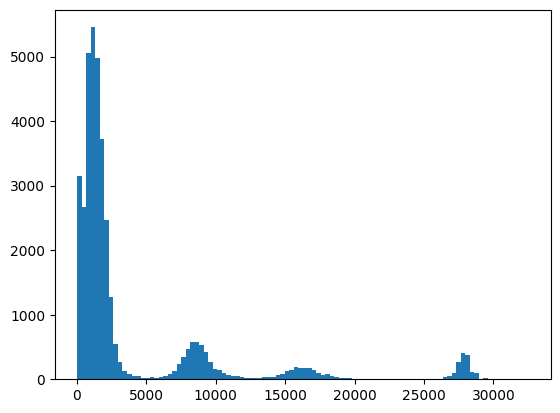

In [12]:
sizes = [len(x) for x in datasets['train']['input_ids']]
plt.hist(sizes, bins=100);